In [1]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font="STIXGeneral", context="talk", palette="colorblind")

import warnings
warnings.filterwarnings('ignore')

R callback write-console: Loading required package: nlme
  
R callback write-console: Loading required package: survival
  
R callback write-console: Loading required package: doParallel
  
R callback write-console: Loading required package: foreach
  
R callback write-console: Loading required package: iterators
  
R callback write-console: Loading required package: parallel
  
R callback write-console: Loading required package: rstan
  
R callback write-console: Loading required package: StanHeaders
  
R callback write-console: 
rstan version 2.32.7 (Stan version 2.32.2)

  
R callback write-console: For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)

  


Index(['id', 'years', 'status', 'drug', 'age', 'sex', 'year', 'ascites',
       'hepatomegaly', 'spiders', 'edema', 'serBilir', 'serChol', 'albumin',
       'alkaline', 'SGOT', 'platelets', 'prothrombin', 'histologic', 'status2',
       'times', 'tte', 'label'],
      dtype='object')


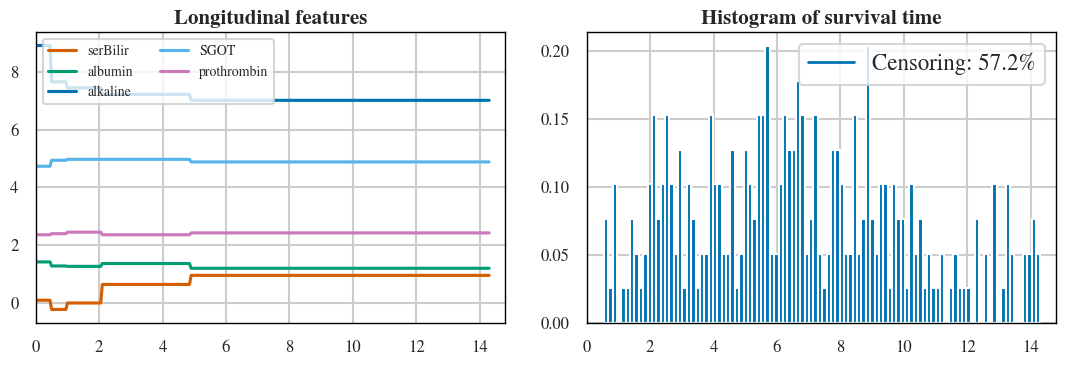

In [2]:
from examples.data.PBC import load_PBC_Seq
paths, surv_labels, longi_feat_list, static_feature, static_feature_list, ddh_info_sup = load_PBC_Seq.load()
longi_feat_list = ['serBilir', 'albumin', 'alkaline', 'SGOT', 'protime']
n_samples, n_sampling_times, _ = paths.shape
n_longi_feats = paths.shape[-1] - 1
sampling_times = paths[0, :, 0]
surv_times, surv_inds = surv_labels[:, 0], surv_labels[:, 1]

In [3]:
# Setup for experiment training
train_test_share = .8
n_samples = paths.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

paths_train = paths[train_index, :, :]
surv_labels_train = surv_labels[train_index, :]
if static_feature is not None:
    static_feature_train = static_feature[train_index, :]
else:
    static_feature_train = None

paths_test = paths[test_index, :, :]
surv_labels_test = surv_labels[test_index, :]
if static_feature is not None:
    static_feature_test = static_feature[test_index, :]
else:
    static_feature_test = None

## Cox Signature

In [4]:
### TRAINING
from examples.learner.coxsig import CoxSignature
sig_order = 2
coxsig = CoxSignature(sig_level=sig_order, alphas=5e-2, max_iter=100)
coxsig.train(paths_train, surv_labels_train, static_feature_train, plot_loss=False)

# setup
sampling_times = np.array(paths[0, :, 0])
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
dt = sampling_times[1] - sampling_times[0]
quantile_pred_times = np.array([.25, .5])
pred_times = ((np.quantile(np.array(tte), quantile_pred_times) - 2 * dt) // dt) * dt
n_eval_times = 3
eval_times = []
for k in range(n_eval_times):
    eval_times.append(max(np.quantile(np.array(tte), quantile_pred_times + (k+1) * .15) - pred_times))
eval_times = np.array(eval_times)

# evaluation
c_index = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index', static_feat = static_feature_test)
bs = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, 'bs', static_feat = static_feature_test)


## Dynamic DeepHit

In [5]:
from examples.learner.dynamic_deephit_ext import construct_df, Dynamic_DeepHit_ext

cont_feat, bin_feat, time_scale, bin_df = ddh_info_sup
df = construct_df(paths.clone(), surv_labels, cont_feat, bin_feat, time_scale, bin_df)

dynamic_deephit = Dynamic_DeepHit_ext()
(data, time_, label), (mask1, mask2, mask3), (data_mi) = dynamic_deephit.preprocess(df, cont_feat, bin_feat)
dynamic_deephit.sampling_times = np.array(sampling_times)
dynamic_deephit.ddh_info_sup = ddh_info_sup

In [6]:
# Setup for experiment training
train_test_share = .8
n_samples = data.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

In [7]:
# split data
tr_data, te_data = data[train_index, :, :], data[test_index, :, :]
tr_data_mi, te_data_mi = data_mi[train_index, :, :], data_mi[test_index, :, :]
tr_time,te_time = time_[train_index, :], time_[test_index, :]
tr_label,te_label = label[train_index, :], label[test_index, :]
tr_mask1,te_mask1 = mask1[train_index, :, :], mask1[test_index, :, :]
tr_mask2,te_mask2 = mask2[train_index, :, :], mask2[test_index, :, :]
tr_mask3,te_mask3 = mask3[train_index, :], mask3[test_index, :]
tr_data_full = (tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)

dynamic_deephit.train(tr_data_full, is_trained=True, ckpt_dir="./dynamic_deephit_ckpt/PBC", plot_loss=False)


# performance evaluation
from examples.learner.utils import score
sampling_times = np.array(paths[0, :, 0])
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.25, .5])
# dt  = dt.item()
pred_times = ((np.quantile(np.array(tte), quantile_pred_times) - 2 * dt) // dt) * dt
n_eval_times = 3
eval_times = []
for k in range(n_eval_times):
    eval_times.append(max(np.quantile(np.array(tte), quantile_pred_times + (k+1) * .15) - pred_times))
eval_times = np.array(eval_times)
# predict
pred_time_scale = (pred_times * time_scale).astype(int)
eval_time_scale = (eval_times * time_scale).astype(int)
ddh_surv_preds = dynamic_deephit.predict(tr_data, tr_data_mi, 
                                         pred_time_scale, eval_time_scale)

n_pred_times = len(pred_times)
n_eval_times = len(eval_times)
ddh_cindex = np.zeros((n_pred_times, n_eval_times))
ddh_bs = np.zeros((n_pred_times, n_eval_times))
for j in np.arange(n_pred_times):
    pred_time = pred_time_scale[j]
    
    # remove individuals whose survival time less than prediction time
    surv_times_test = tr_time.flatten()
    surv_inds_test = tr_label.flatten()
    idx_sel = surv_times_test >= pred_time
    surv_times_ = surv_times_test[idx_sel] - pred_time
    surv_inds_ = surv_inds_test[idx_sel]
    surv_labels_ = np.array([surv_times_, surv_inds_]).T
    surv_preds_ = ddh_surv_preds[:, j][idx_sel]

    ddh_cindex[j] = score("c_index", surv_labels_, surv_labels_, 
                          surv_preds_, eval_time_scale)

    ddh_bs[j] = score("bs", surv_labels_, surv_labels_, 
                          surv_preds_, eval_time_scale)

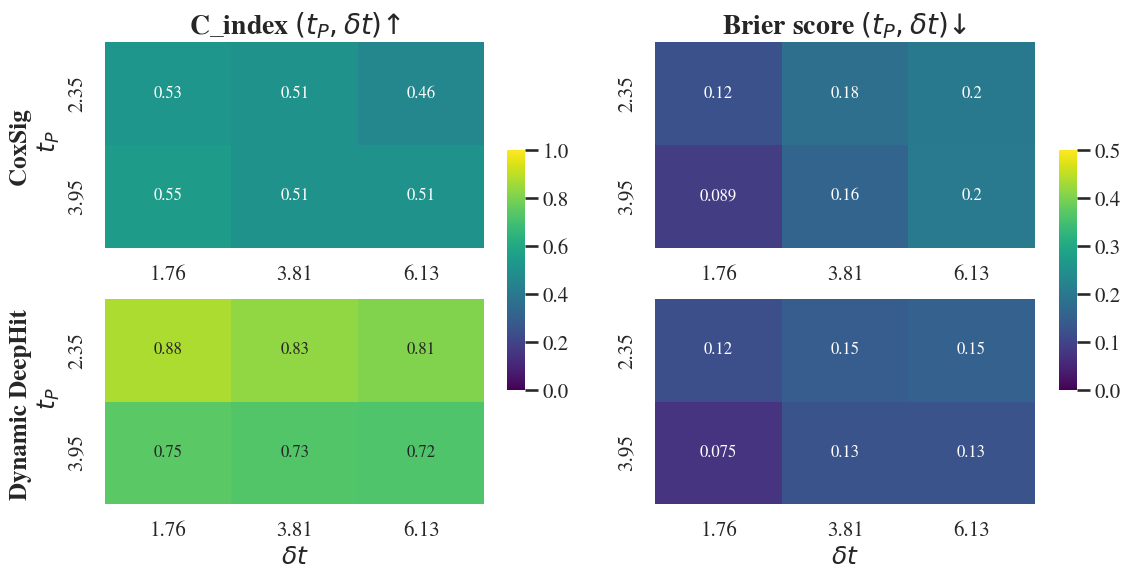

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
for ax_ in axs:
    for ax in ax_:
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_edgecolor('black')

plt.subplots_adjust(hspace=.25, wspace=0.45)
cbar_ax_1 = fig.add_axes([0.46, 0.3, 0.015, 0.4])  # [left, bottom, width, height]
vmin = 0.
vmax = 1
sns.heatmap(c_index, annot=True, annot_kws={"size": 12}, cmap="viridis", vmin=vmin, vmax=vmax, ax=axs[0, 0], cbar=False)
axs[0, 0].set_xticklabels([str(round(x, 2)) for x in eval_times])
axs[0, 0].set_yticklabels([str(round(x, 2)) for x in pred_times])
axs[0, 0].tick_params(axis='y', labelsize=15)
axs[0, 0].tick_params(axis='x', labelsize=15)
axs[0, 0].set_ylabel("CoxSig \n $t_P$", fontweight="semibold", fontsize=18)
axs[0, 0].set_title("C_index $(t_P, \delta t) \u2191$", fontweight="semibold", fontsize=20)
axs[0, 0].legend().remove()

sns.heatmap(ddh_cindex, annot=True, annot_kws={"size": 12}, cmap="viridis", ax=axs[1, 0], vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cbar_ax_1)
axs[1, 0].set_xticklabels([str(round(x, 2)) for x in eval_times])
axs[1, 0].set_yticklabels([str(round(x, 2)) for x in pred_times])
axs[1, 0].tick_params(axis='y', labelsize=15)
axs[1, 0].tick_params(axis='x', labelsize=15)
axs[1, 0].set_xlabel("$\delta t$", fontweight="semibold", fontsize=18)
axs[1, 0].set_ylabel("Dynamic DeepHit \n $t_P$", fontweight="semibold", fontsize=18)
axs[1, 0].collections[0].colorbar.ax.tick_params(labelsize=15)
axs[1, 0].legend().remove()

cbar_ax_2 = fig.add_axes([0.92, 0.3, 0.015, 0.4])  # [left, bottom, width, height]
vmin = 0
vmax = .5

sns.heatmap(bs, annot=True, annot_kws={"size": 12}, cmap="viridis", ax=axs[0, 1], vmin=vmin, vmax=vmax, cbar=False)
axs[0, 1].set_xticklabels([str(round(x, 2)) for x in eval_times])
axs[0, 1].set_yticklabels([str(round(x, 2)) for x in pred_times])
axs[0, 1].tick_params(axis='y', labelsize=15)
axs[0, 1].tick_params(axis='x', labelsize=15)
axs[0, 1].set_title("Brier score $(t_P, \delta t) \u2193$", fontweight="semibold", fontsize=20)
axs[0, 1].legend().remove()


sns.heatmap(ddh_bs, annot=True, annot_kws={"size": 12}, cmap="viridis", ax=axs[1, 1], vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cbar_ax_2)
axs[1, 1].set_xticklabels([str(round(x, 2)) for x in eval_times])
axs[1, 1].set_yticklabels([str(round(x, 2)) for x in pred_times])
axs[1, 1].tick_params(axis='y', labelsize=15)
axs[1, 1].tick_params(axis='x', labelsize=15)
axs[1, 1].set_xlabel("$\delta t$", fontweight="semibold", fontsize=18)
axs[1, 1].collections[0].colorbar.ax.tick_params(labelsize=15)
axs[1, 1].legend().remove()

### Expected remaining survival time as prediction function

In [9]:
all_shap_CoxSig= np.load('results/shap_PBC_mean_CoxSig.npy', allow_pickle=True)
all_shap_DDH= np.load('results/shap_PBC_mean_DDH.npy', allow_pickle=True)
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.25, .5])
pred_times = np.quantile(np.array(tte), quantile_pred_times)
x_labels =  ['serBilir', 'albumin', 'alkaline', 'SGOT', 'protime', 'edema', 'age']
colors = ["r", "g", "b", "c", "m", "#E69F00", "#5E3C99", "#ff9896"]

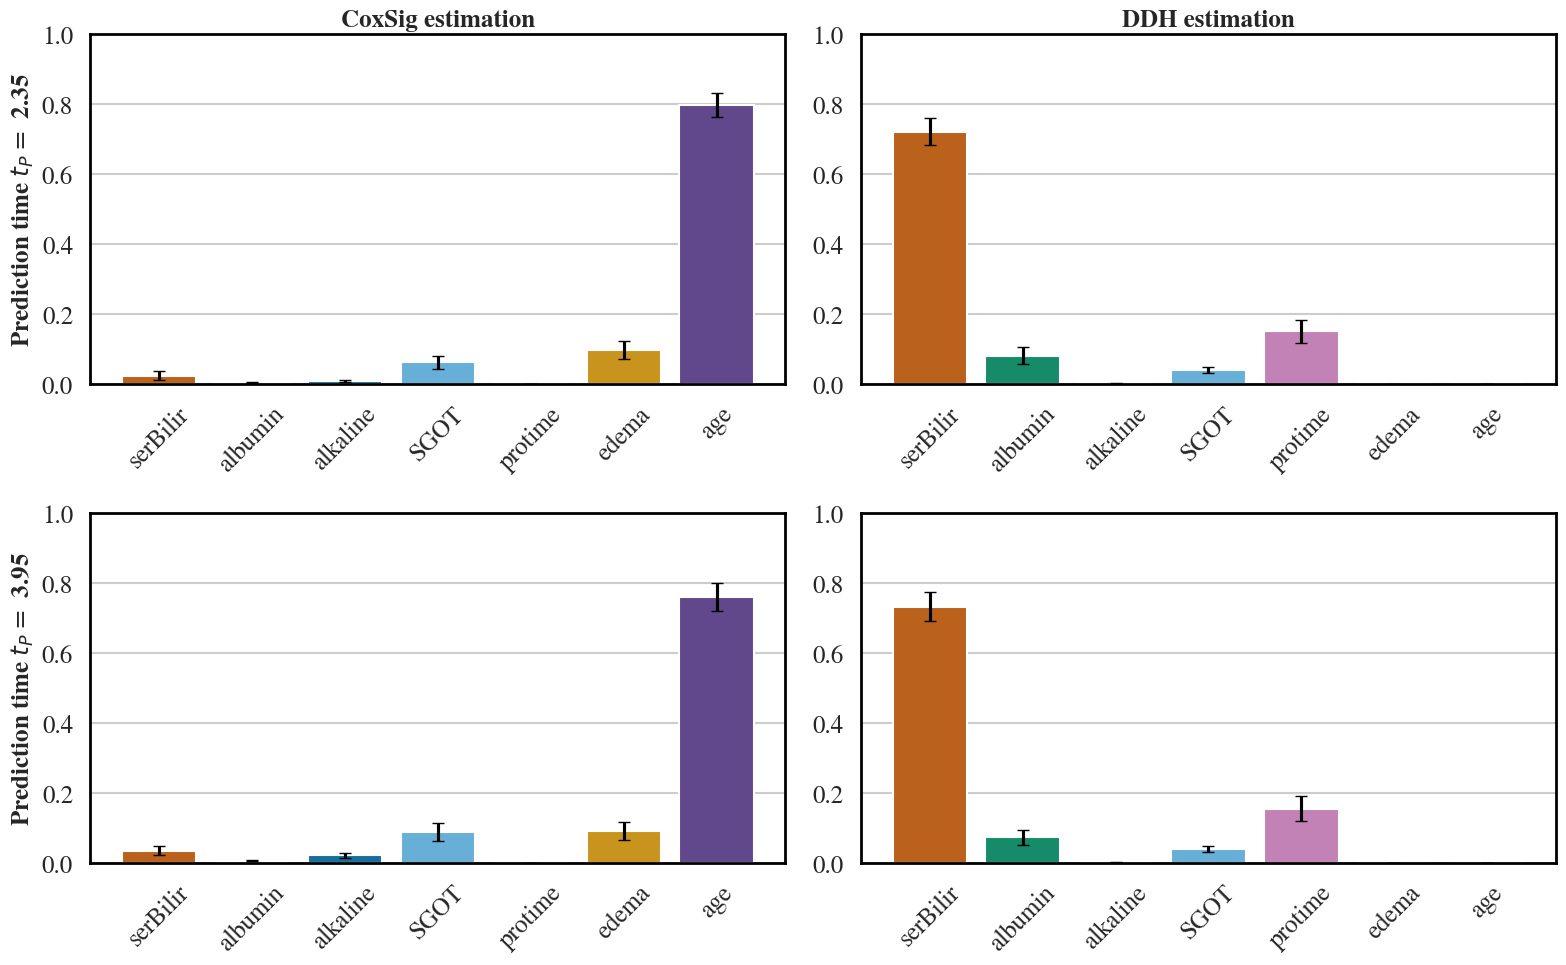

In [10]:
def compute_IS(all_shap):
    shap_at_pt = []
    # all_shap = np.array(all_shap_CoxSig[idx_pred_t])
    n_expl_samples = all_shap.shape[0]
    for i in range(n_expl_samples):
        a, b = np.asarray(all_shap[i][0], dtype=float), np.asarray(all_shap[i][1], dtype=float)
        tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
        if len(np.unique(tmp)) > 2:
            shap_at_pt.append(tmp)
    mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
    ci_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
    std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0) / np.sqrt(len(shap_at_pt))
    shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
    est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
    est_score_df["value"] = est_score_df["value"].astype(float)

    return est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat

def plot_IS_feat(est_score_df, ci_shap_at_pt, ax):
    sns.barplot(data=est_score_df, x="feat", y="value", ax=ax, palette=colors)
    ax.errorbar(
        x=np.arange(ci_shap_at_pt.shape[0]),
        y=shap_per_feat,
        yerr=ci_shap_at_pt,
        fmt='none',
        c='black',
        capsize=4
    )
    ax.tick_params(axis='x', labelsize=18, labelrotation=45) 
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(0, .8)

def plot_IS_longi(mean_shap_at_pt, std_shap_at_pt, ax):
    for l in range(n_longi_feats):
        label = f"${{\mathbf{{I}}}}(" + "\\mathbf{"+ longi_feat_list[l] +"}" + ",\Omega,Y_{{\leq t_{{\mathrm{{P}}}}}})$"
        ax.plot(sampling_times, mean_shap_at_pt[l], linewidth=3, color=colors[l], label=label)
        ax.fill_between(sampling_times, mean_shap_at_pt[l] - 1.96 * std_shap_at_pt[l], mean_shap_at_pt[l] + 1.96 * std_shap_at_pt[l], color=colors[l], alpha=0.2)
    ax.tick_params(axis='x', labelsize=18) 
    ax.tick_params(axis='y', labelsize=18)
    ax.set_ylim(0, .08)


fig, axs = plt.subplots(2, 2, figsize=(16,10))

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]

dt = sampling_times[1] - sampling_times[0]

idx_pred_t = 0
est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_CoxSig[idx_pred_t]))
plot_IS_feat(est_score_df, ci_shap_at_pt, axs[0, 0])
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
axs[0, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")
axs[0, 0].set_title("CoxSig estimation", fontsize=18, fontweight="semibold")
axs[0, 0].set_ylim(0, 1.)


est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_DDH[idx_pred_t]))
plot_IS_feat(est_score_df, ci_shap_at_pt, axs[0, 1])
axs[0, 1].set_title("DDH estimation", fontsize=18, fontweight="semibold")
axs[0, 1].set_ylim(0, 1.)


idx_pred_t = 1
est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_CoxSig[idx_pred_t]))
plot_IS_feat(est_score_df, ci_shap_at_pt, axs[1, 0])
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
axs[1, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")
axs[1, 0].set_ylim(0, 1.)


est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_DDH[idx_pred_t]))
plot_IS_feat(est_score_df, ci_shap_at_pt, axs[1, 1])
axs[1, 1].set_ylim(0, 1.)

plt.tight_layout()
plt.savefig('figures/shap_PBC_mean_score_per_feat.pdf')
plt.show()

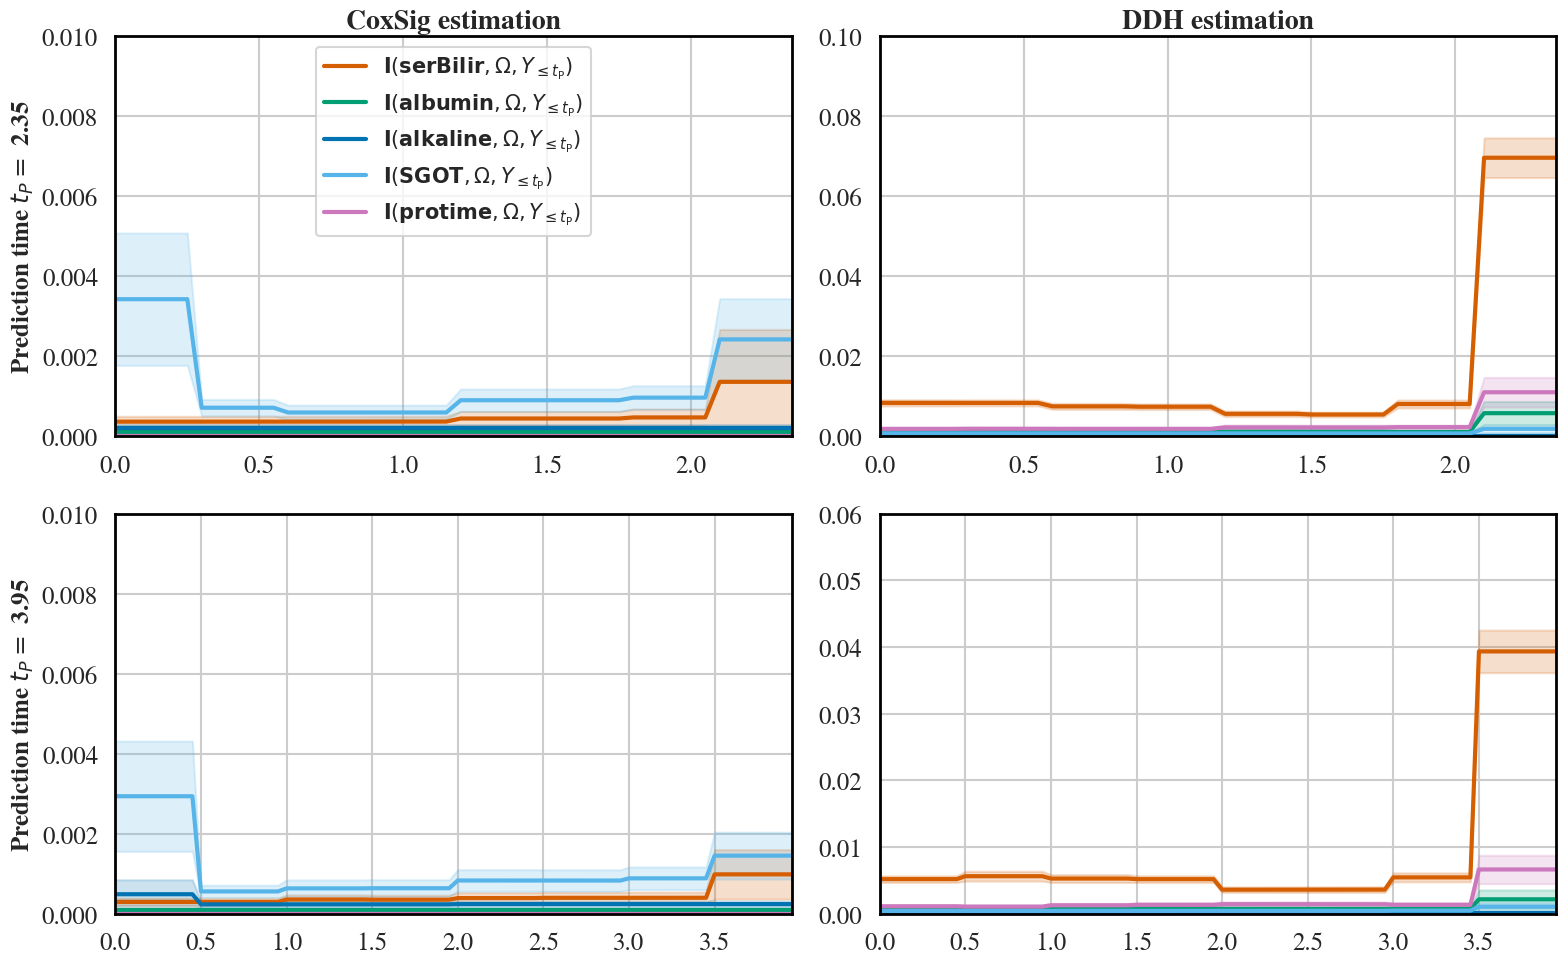

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]


idx_pred_t = 0
est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_CoxSig[idx_pred_t]))
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
plot_IS_longi(mean_shap_at_pt, std_shap_at_pt, axs[0, 0])
axs[0, 0].legend(ncols=1, fontsize=15, loc="upper center")
axs[0, 0].set_title("CoxSig estimation", fontweight="semibold", fontsize=20)
# axs[0, 0].legend(ncols=1, fontsize=15, loc="upper left")
axs[0, 0].set_xlim(0, (pred_time_idx - 1) * dt)
axs[0, 0].set_ylim(0, .01)
axs[0, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")

est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_DDH[idx_pred_t]))
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
plot_IS_longi(mean_shap_at_pt, std_shap_at_pt, axs[0, 1])
axs[0, 1].set_title("DDH estimation", fontweight="semibold", fontsize=20)
axs[0, 1].set_xlim(0, (pred_time_idx - 1) * dt)
axs[0, 1].set_ylim(0, .1)


idx_pred_t = 1
est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_CoxSig[idx_pred_t]))
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
plot_IS_longi(mean_shap_at_pt, std_shap_at_pt, axs[1, 0])
axs[1, 0].set_ylim(0, .01)
axs[1, 0].set_xlim(0, (pred_time_idx - 1) * dt)
axs[1, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")

est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_DDH[idx_pred_t]))
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
plot_IS_longi(mean_shap_at_pt, std_shap_at_pt, axs[1, 1])
axs[1, 1].set_ylim(0, .06)
axs[1, 1].set_xlim(0, (pred_time_idx - 1) * dt)

plt.tight_layout()
plt.savefig('figures/shap_PBC_mean_score_per_longi.pdf')
plt.show()

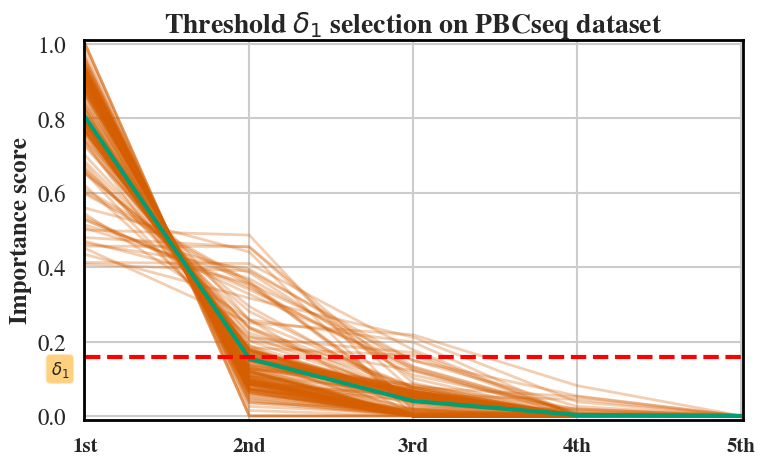

In [12]:
idx_pred_t = 1
shap_at_pt = []
all_shap = np.array(all_shap_DDH)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)


fig, axs = plt.subplots(1, 1, figsize=(8,5))
props1 = dict(boxstyle='round', facecolor='orange', alpha=0.5)

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]

res = np.nansum(np.array(shap_at_pt)[:, :n_longi_feats], axis=-1)

ax = fig.axes[0]
new_res = []
for tmp in res:
    if not np.all(tmp == 0):
        ax.plot(np.sort(tmp)[::-1], color='r', linewidth=2, zorder=1, alpha=.3)
        new_res.append(np.sort(tmp)[::-1])

mean = np.mean(np.array(new_res), axis=0)
ax.plot(np.arange(n_longi_feats), mean, color='g', linewidth=3, zorder=2)
ax.hlines(xmin=0, xmax=4, y=1.1/7, linewidth=3, color='red',linestyle='--')
ax.set_xlim(-0.01, 4.01)
ax.set_ylim(-0.01, 1.01)
ax.set_ylabel("Importance score", fontsize=18, fontweight="semibold")
ax.set_xticks(np.arange(0, n_longi_feats))
ax.set_xticklabels(["1st", "2nd", "3rd", "4th", "5th"], fontsize=15, fontweight="semibold")
ax.text(-0.05, .16, '$\delta_1$', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props1)
ax.set_title("Threshold $\delta_1$ selection on PBCseq dataset", fontsize=20, fontweight="semibold")
plt.tight_layout()
plt.savefig('figures/PBC_optimal_threshold.pdf')


### Median survival time as prediction function

In [13]:
all_shap_CoxSig= np.load('results/shap_PBC_med_CoxSig.npy', allow_pickle=True)
all_shap_DDH= np.load('results/shap_PBC_med_DDH.npy', allow_pickle=True)
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.25, .5])
pred_times = np.quantile(np.array(tte), quantile_pred_times)
x_labels =  ['serBilir', 'albumin', 'alkaline', 'SGOT', 'protime', 'edema', 'age']
colors = ["r", "g", "b", "c", "m", "#E69F00", "#5E3C99", "#ff9896"]

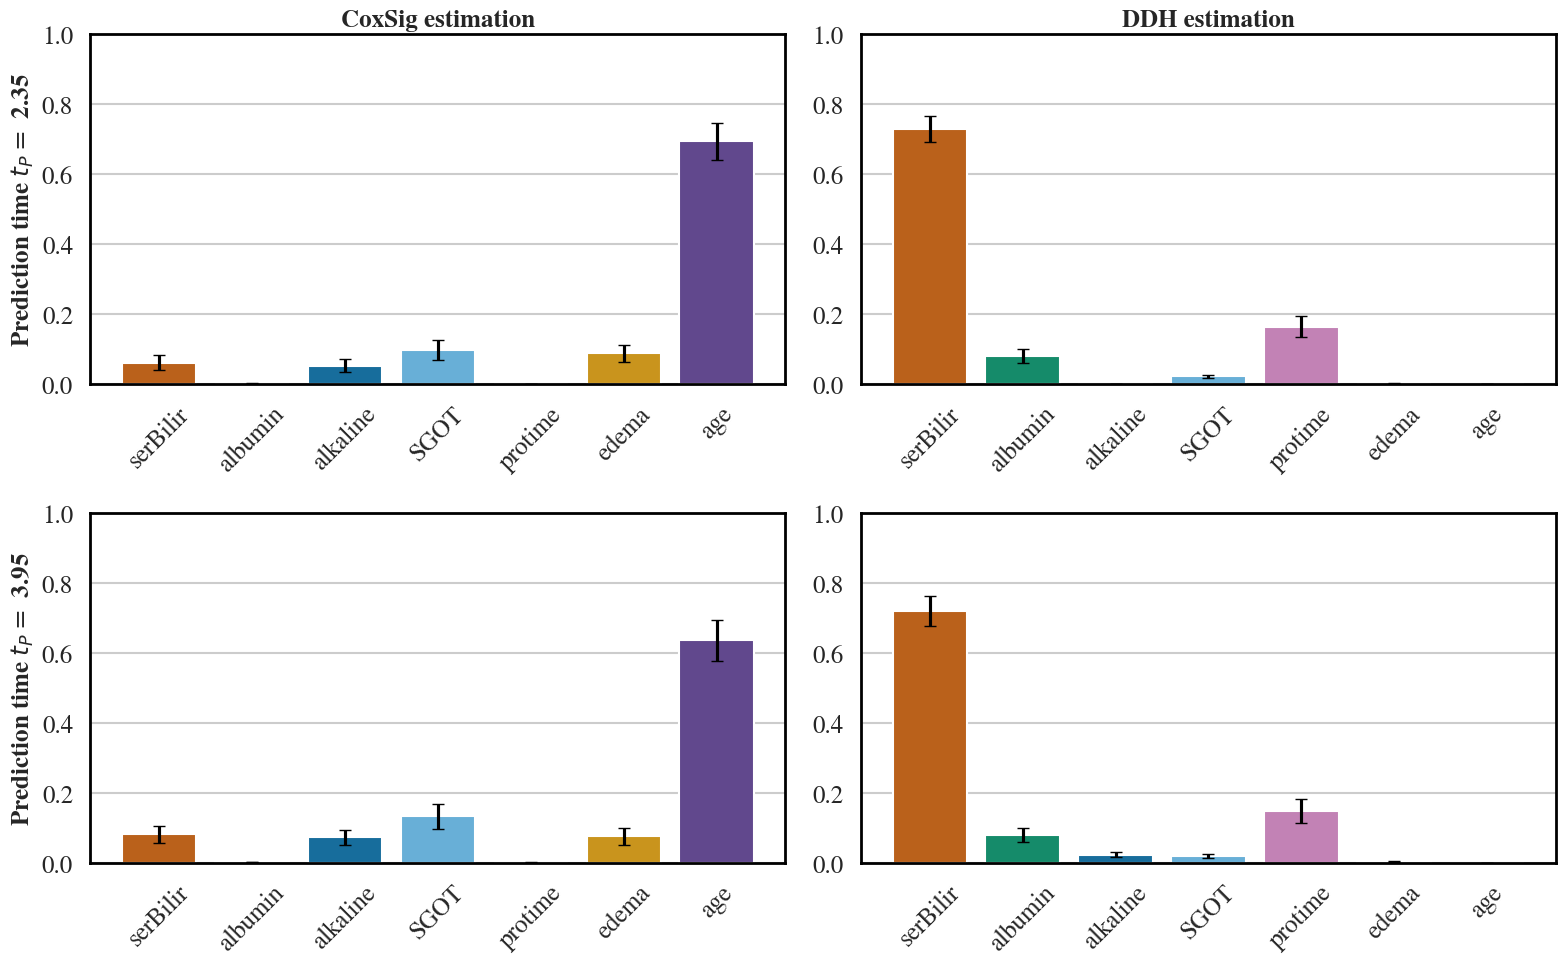

In [14]:
def compute_IS(all_shap):
    shap_at_pt = []
    # all_shap = np.array(all_shap_CoxSig[idx_pred_t])
    n_expl_samples = all_shap.shape[0]
    for i in range(n_expl_samples):
        a, b = np.asarray(all_shap[i][0], dtype=float), np.asarray(all_shap[i][1], dtype=float)
        tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
        if len(np.unique(tmp)) > 2:
            shap_at_pt.append(tmp)
    mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
    ci_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
    std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0) / np.sqrt(len(shap_at_pt))
    shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
    est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
    est_score_df["value"] = est_score_df["value"].astype(float)

    return est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat

def plot_IS_feat(est_score_df, ci_shap_at_pt, ax):
    sns.barplot(data=est_score_df, x="feat", y="value", ax=ax, palette=colors)
    ax.errorbar(
        x=np.arange(ci_shap_at_pt.shape[0]),
        y=shap_per_feat,
        yerr=ci_shap_at_pt,
        fmt='none',
        c='black',
        capsize=4
    )
    ax.tick_params(axis='x', labelsize=18, labelrotation=45) 
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(0, .8)

def plot_IS_longi(mean_shap_at_pt, std_shap_at_pt, ax):
    for l in range(n_longi_feats):
        label = f"${{\mathbf{{I}}}}(" + "\\mathbf{"+ longi_feat_list[l] +"}" + ",\Omega,Y_{{\leq t_{{\mathrm{{P}}}}}})$"
        ax.plot(sampling_times, mean_shap_at_pt[l], linewidth=3, color=colors[l], label=label)
        ax.fill_between(sampling_times, mean_shap_at_pt[l] - 1.96 * std_shap_at_pt[l], mean_shap_at_pt[l] + 1.96 * std_shap_at_pt[l], color=colors[l], alpha=0.2)
    ax.tick_params(axis='x', labelsize=18) 
    ax.tick_params(axis='y', labelsize=18)
    ax.set_ylim(0, .08)


fig, axs = plt.subplots(2, 2, figsize=(16,10))

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]

dt = sampling_times[1] - sampling_times[0]

idx_pred_t = 0
est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_CoxSig[idx_pred_t]))
plot_IS_feat(est_score_df, ci_shap_at_pt, axs[0, 0])
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
axs[0, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")
axs[0, 0].set_title("CoxSig estimation", fontsize=18, fontweight="semibold")
axs[0, 0].set_ylim(0, 1.)


est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_DDH[idx_pred_t]))
plot_IS_feat(est_score_df, ci_shap_at_pt, axs[0, 1])
axs[0, 1].set_title("DDH estimation", fontsize=18, fontweight="semibold")
axs[0, 1].set_ylim(0, 1.)


idx_pred_t = 1
est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_CoxSig[idx_pred_t]))
plot_IS_feat(est_score_df, ci_shap_at_pt, axs[1, 0])
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
axs[1, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")
axs[1, 0].set_ylim(0, 1.)


est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_DDH[idx_pred_t]))
plot_IS_feat(est_score_df, ci_shap_at_pt, axs[1, 1])
axs[1, 1].set_ylim(0, 1.)

plt.tight_layout()
plt.savefig('figures/shap_PBC_med_score_per_feat.pdf')
plt.show()

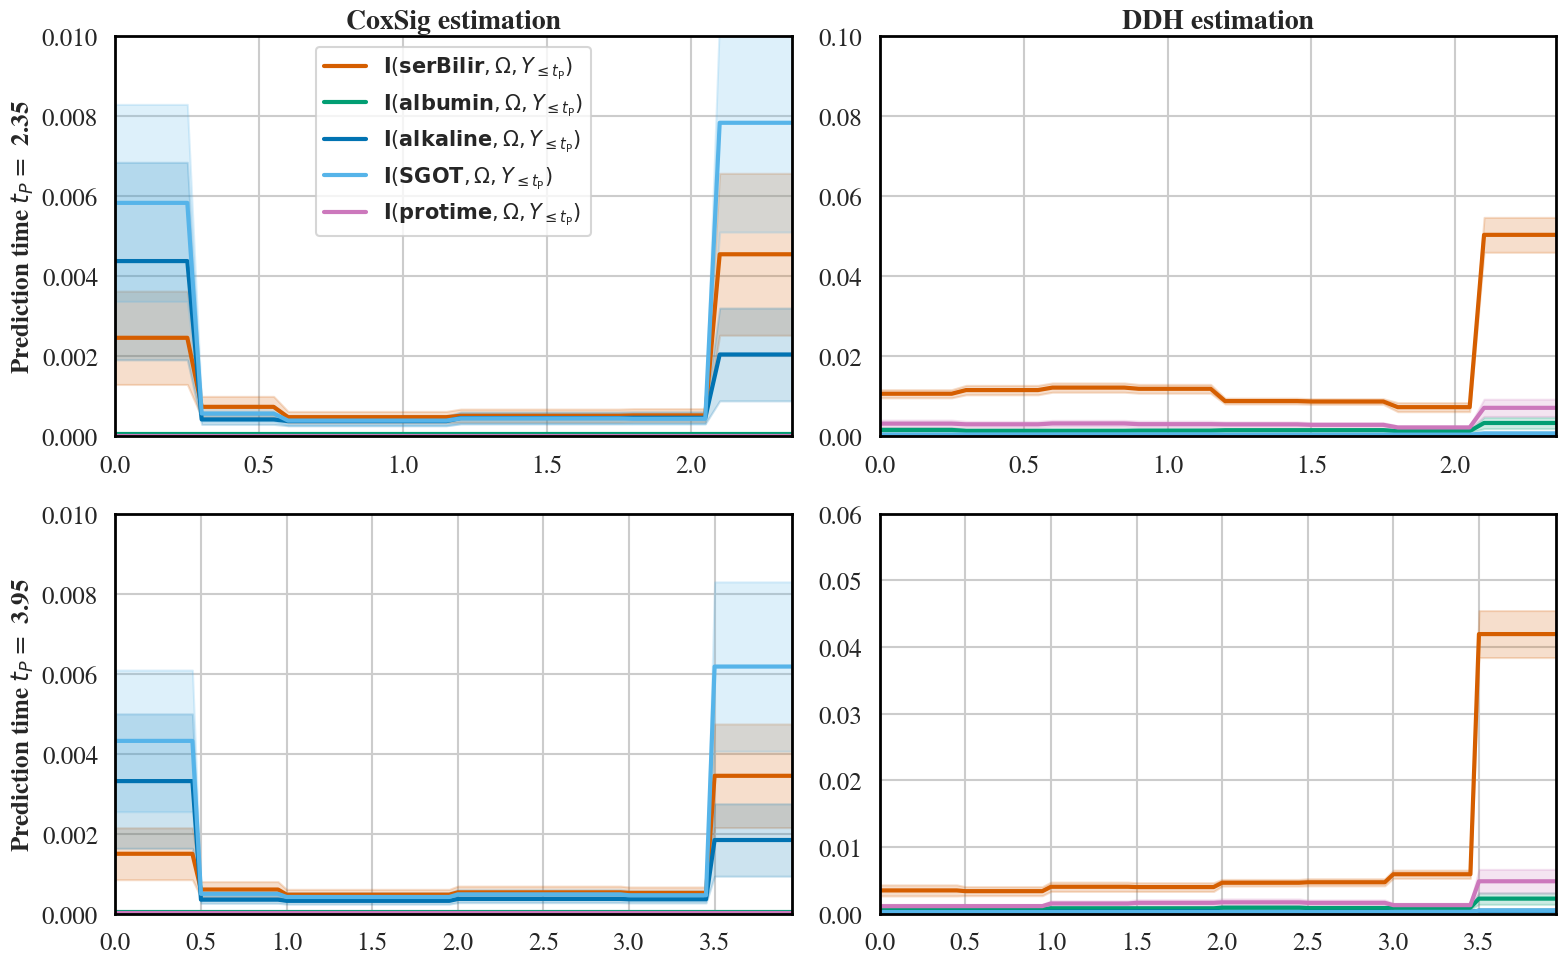

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]


idx_pred_t = 0
est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_CoxSig[idx_pred_t]))
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
plot_IS_longi(mean_shap_at_pt, std_shap_at_pt, axs[0, 0])
axs[0, 0].legend(ncols=1, fontsize=15, loc="upper center")
axs[0, 0].set_title("CoxSig estimation", fontweight="semibold", fontsize=20)
# axs[0, 0].legend(ncols=1, fontsize=15, loc="upper left")
axs[0, 0].set_xlim(0, (pred_time_idx - 1) * dt)
axs[0, 0].set_ylim(0, .01)
axs[0, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")

est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_DDH[idx_pred_t]))
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
plot_IS_longi(mean_shap_at_pt, std_shap_at_pt, axs[0, 1])
axs[0, 1].set_title("DDH estimation", fontweight="semibold", fontsize=20)
axs[0, 1].set_xlim(0, (pred_time_idx - 1) * dt)
axs[0, 1].set_ylim(0, .1)


idx_pred_t = 1
est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_CoxSig[idx_pred_t]))
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
plot_IS_longi(mean_shap_at_pt, std_shap_at_pt, axs[1, 0])
axs[1, 0].set_ylim(0, .01)
axs[1, 0].set_xlim(0, (pred_time_idx - 1) * dt)
axs[1, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")

est_score_df, mean_shap_at_pt, std_shap_at_pt, ci_shap_at_pt, shap_per_feat = compute_IS(np.array(all_shap_DDH[idx_pred_t]))
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
plot_IS_longi(mean_shap_at_pt, std_shap_at_pt, axs[1, 1])
axs[1, 1].set_ylim(0, .06)
axs[1, 1].set_xlim(0, (pred_time_idx - 1) * dt)

plt.tight_layout()
plt.savefig('figures/shap_PBC_med_score_per_longi.pdf')
plt.show()